In [2]:
!pip install -qq BorutaShap

In [3]:
import warnings
warnings.filterwarnings("ignore")

import time
from tqdm import tqdm
from itertools import combinations

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold

from functools import partial

import catboost
from catboost import CatBoostClassifier, Pool

from BorutaShap import BorutaShap

In [4]:
def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: str = None,
                          suffix: str = None,
                          ) -> pd.DataFrame:
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".lower() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

def find_max_consequtive(x):
    if isinstance(x, int):
        return x
    max_c, run_m = 1, 1
    for i in range(1, len(x)):
        if x[i] - x[i-1] == 1:
            run_m += 1
        else:
            if max_c < run_m:
                max_c = run_m
            run_m = 1
    return max_c

def find_min_delta(x):
    min_delta = 365
    length = len(x)
    if length < 2:
        return min_delta
    
    for i in range(1, len(x)):
        delta = x[i] - x[i-1]
        if delta < min_delta:
            min_delta = delta
    return min_delta

def find_mean_delta(x):
    mean_delta = 365
    length = len(x)
    if length < 2:
        return mean_delta
    
    deltas = []
    for i in range(1, len(x)):
        deltas.append(x[i] - x[i-1])
    return np.mean(deltas)

def find_max_delta(x):
    max_delta = 0
    length = len(x)
    if length < 2:
        return max_delta
    
    for i in range(1, len(x)):
        delta = x[i] - x[i-1]
        if delta > max_delta:
            max_delta = delta
    return max_delta

In [5]:
users = pd.read_csv("/kaggle/input/onlineretail/OnlineRetail.csv", parse_dates=["InvoiceDate"], encoding='unicode_escape')
users["InvoiceDate"] = pd.to_datetime(users["InvoiceDate"].dt.date)
users.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [6]:
# taking only UK
users_uk = users[users["Country"] == "United Kingdom"]
users_uk.drop("Country", axis=1, inplace=True)

# split into target and working datasets: better select more months in target, e.g. 3 months!
users_nov = users_uk[(users_uk["InvoiceDate"] > "2011-08-31") & (users_uk["InvoiceDate"] < "2011-12-01")]
users_prev = users_uk[users_uk["InvoiceDate"] < "2011-09-01"]

# remove unavailable customer ids
users_prev = users_prev[users_prev["CustomerID"].notna()]
users_nov = users_nov[users_nov["CustomerID"].notna()]

# compute churn target: users who never order anything in november
users_prev["target"] = 1 - users_prev["CustomerID"].isin(users_nov["CustomerID"]).astype(int)

# lower description
users_prev["Description"] = users_prev["Description"].str.lower()

# revenue
users_prev["Revenue"] = users_prev["UnitPrice"] * users_prev["Quantity"]

# add date features
users_prev["DayMonth"] = users_prev["InvoiceDate"].dt.day.astype("str")
users_prev["DayWeek"] = users_prev["InvoiceDate"].dt.dayofweek.astype("str")
users_prev["Month"] = users_prev["InvoiceDate"].dt.month.astype("str")
users_prev["WeekOfYear"] = users_prev["InvoiceDate"].dt.week
users_prev["DayOfYear"] = users_prev["InvoiceDate"].dt.dayofyear

# calculate total customer's statistics
aggs = {"Quantity": ["sum", "max", "min", "count"], "UnitPrice": ["mean", "max", "sum", "min"]}
stats = create_numerical_aggs(users_prev, groupby_id="CustomerID", aggs=aggs, suffix="_by_id")
users_prev = pd.merge(users_prev, stats, on="CustomerID", how="left")

# number of returned orders
qneg_users = users_prev[users_prev["Quantity"] < 0]
qneg_users = qneg_users.groupby("CustomerID", as_index=False)["Quantity"].count() # ["Quantity"].transform("count")
qneg_users.columns = ["CustomerID", "return_cnt"]

users_prev = users_prev.merge(qneg_users, on="CustomerID", how="left")
users_prev.fillna(0, inplace=True)

# number of max consequtive days of ordering
tmp = pd.concat([users_prev["CustomerID"], users_prev["DayOfYear"]], axis=1).sort_values(["CustomerID", "DayOfYear"])
tmp.drop_duplicates(inplace=True)
tmp = tmp.groupby("CustomerID", as_index=True).agg({"DayOfYear": lambda x: (x - x.min() + 1)})
tmp = tmp["DayOfYear"].apply(lambda x: find_max_consequtive(x.tolist()))
tmp = tmp.reset_index()
tmp = tmp.rename(columns={"DayOfYear": "conseq"})
users_prev = users_prev.merge(tmp, on="CustomerID", how="left")

# min, max, mean days between orders
tmp = users_prev.groupby(["CustomerID"], as_index=False).agg({"DayOfYear": lambda x: sorted(list(set(x)))}).rename(columns={"DayOfYear": "DaysList"})
tmp["min_delta"] = tmp["DaysList"].apply(find_min_delta)
tmp["max_delta"] = tmp["DaysList"].apply(find_max_delta)
tmp["mean_delta"] = tmp["DaysList"].apply(find_mean_delta)
tmp.drop("DaysList", axis=1, inplace=True)

users_prev = users_prev.merge(tmp, on="CustomerID", how="left")

# compute monthly quantity and unit prices
# groupby(["CustomerID", "Month"])["Revenue"].sum().unstack()
aggs = {"Quantity": ["sum",],
        "Revenue": ["sum",]}

for month in users_prev["Month"].unique():
    stats = create_numerical_aggs(users_prev[users_prev["Month"] == month], groupby_id=["CustomerID", "Month"], aggs=aggs, suffix=f"_by_id_month_{month}")
    stats.drop("Month", axis=1, inplace=True)
    users_prev = users_prev.merge(stats, on=["CustomerID"], how="left")
    
users_prev.fillna(0, inplace=True)  # assuming no orders in current month

users_prev["mean_upr_mothly"] = users_prev[['revenue_sum_by_id_month_12',
                                             'revenue_sum_by_id_month_1',
                                             'revenue_sum_by_id_month_2',
                                             'revenue_sum_by_id_month_3',
                                             'revenue_sum_by_id_month_4',
                                             'revenue_sum_by_id_month_5',
                                             'revenue_sum_by_id_month_6',
                                             'revenue_sum_by_id_month_7',
                                             'revenue_sum_by_id_month_8',
                                            # 'unitprice_sum_by_id_month_9',
                                            # 'unitprice_sum_by_id_month_10'
                                           ]].mean(axis=1)

users_prev["stdv_upr_mothly"] = users_prev[['revenue_sum_by_id_month_12',
                                             'revenue_sum_by_id_month_1',
                                             'revenue_sum_by_id_month_2',
                                             'revenue_sum_by_id_month_3',
                                             'revenue_sum_by_id_month_4',
                                             'revenue_sum_by_id_month_5',
                                             'revenue_sum_by_id_month_6',
                                             'revenue_sum_by_id_month_7',
                                             'revenue_sum_by_id_month_8',
                                            # 'unitprice_sum_by_id_month_9',
                                            # 'unitprice_sum_by_id_month_10'
                                           ]].std(axis=1)

users_prev["mean_qnt_mothly"] = users_prev[['quantity_sum_by_id_month_12',
                                            'quantity_sum_by_id_month_1',
                                            'quantity_sum_by_id_month_2',
                                            'quantity_sum_by_id_month_3',
                                            'quantity_sum_by_id_month_4',
                                            'quantity_sum_by_id_month_5',
                                            'quantity_sum_by_id_month_6',
                                            'quantity_sum_by_id_month_7',
                                            'quantity_sum_by_id_month_8',
                                           # 'quantity_sum_by_id_month_9',
                                           # 'quantity_sum_by_id_month_10'
                                           ]].mean(axis=1)

users_prev["stdv_qnt_mothly"] = users_prev[['quantity_sum_by_id_month_12',
                                            'quantity_sum_by_id_month_1',
                                            'quantity_sum_by_id_month_2',
                                            'quantity_sum_by_id_month_3',
                                            'quantity_sum_by_id_month_4',
                                            'quantity_sum_by_id_month_5',
                                            'quantity_sum_by_id_month_6',
                                            'quantity_sum_by_id_month_7',
                                            'quantity_sum_by_id_month_8',
                                           # 'quantity_sum_by_id_month_9',
                                           # 'quantity_sum_by_id_month_10'
                                           ]].std(axis=1)

# ratios of revenue and quantity
users_prev["rev_678_to_345"] = users_prev[['revenue_sum_by_id_month_6', 'revenue_sum_by_id_month_7', 'revenue_sum_by_id_month_8']].sum(axis=1) \
                                    / users_prev[['revenue_sum_by_id_month_3', 'revenue_sum_by_id_month_4', 'revenue_sum_by_id_month_5',]].sum(axis=1)

users_prev["qnt_678_to_345"] = users_prev[['quantity_sum_by_id_month_6', 'quantity_sum_by_id_month_7', 'quantity_sum_by_id_month_8',]].sum(axis=1) \
                                    / users_prev[['quantity_sum_by_id_month_3', 'quantity_sum_by_id_month_4', 'quantity_sum_by_id_month_5',]].sum(axis=1)

# lifetimes style recency: last date - first date 
tmp = users_prev.groupby("CustomerID", as_index=False).agg({"InvoiceDate": lambda x: (x.max() - x.min()).days}).rename(columns={"InvoiceDate": "LTRecency"})
users_prev = users_prev.merge(tmp, on="CustomerID", how="left")

# compute frequency
tmp = users_prev.groupby("CustomerID", as_index=False)["InvoiceNo"].count().rename(columns={"InvoiceNo": "frequency"})
users_prev = users_prev.merge(tmp, on="CustomerID", how="left")

# compute recency
df_recency = users_prev.groupby("CustomerID", as_index=False)["InvoiceDate"].max()
df_recency.columns = ['CustomerID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()

df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
df_recency.drop("LastPurchaseDate", axis=1, inplace=True)

users_prev = users_prev.merge(df_recency, on="CustomerID", how="left")

users_prev['R_rank'] = users_prev['Recency'].rank(ascending=False)
users_prev['F_rank'] = users_prev['frequency'].rank(ascending=True)
users_prev['M_rank'] = users_prev['Revenue'].rank(ascending=True)

# normalizing rank
users_prev['R_rank'] = (users_prev['R_rank']/users_prev['R_rank'].max())*100
users_prev['F_rank'] = (users_prev['F_rank']/users_prev['F_rank'].max())*100
users_prev['M_rank'] = (users_prev['F_rank']/users_prev['M_rank'].max())*100

# calculating RFM-score
alpha = beta = gamma = 1
mult = 0.05

users_prev['RFM_Score'] = alpha * users_prev['R_rank'] + beta * users_prev['F_rank'] + gamma * users_prev['M_rank']
users_prev['RFM_Score'] *= mult

# text features: cut on most recent 1000 tokens
tmp = users_prev.sort_values("InvoiceDate").groupby(["CustomerID"], as_index=False)["Description"].sum().rename(columns={"Description": "Text"})
tmp["Text"] = tmp["Text"].apply(lambda x: " ".join(x.split()[-1000:]))
users_prev = users_prev.merge(tmp, on="CustomerID", how="left").drop("Description", axis=1)

In [6]:
users_prev.head(2)  # nans are where customer had no orders in first 3 months. CatBoost uses min nan mode to separate it.

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,target,Revenue,DayMonth,DayWeek,...,rev_678_to_345,qnt_678_to_345,LTRecency,frequency,Recency,R_rank,F_rank,M_rank,RFM_Score,Text
0,536365,85123A,6,2010-12-01,2.55,17850.0,1,15.30,1,2,...,NaN,NaN,71,312,202,4.205177,76.582104,0.037329,4.04123,antique white wooden picture frame white finis...
1,536365,71053,6,2010-12-01,3.39,17850.0,1,20.34,1,2,...,NaN,NaN,71,312,202,4.205177,76.582104,0.037329,4.04123,antique white wooden picture frame white finis...


In [7]:
users_prev["CustomerID"].nunique()  # small amount of unique users

3027

In [7]:
# aggregate everything
users = users_prev.groupby("CustomerID").agg({
    "StockCode": ["last", lambda x: x.nunique()],
    "target": "last",
    "Revenue": "last",
    "DayWeek": lambda x: x.value_counts().index[0],
    "Month": "last",
    "quantity_sum_by_id": "last",
    'quantity_max_by_id': "last",
    'quantity_min_by_id': "last", 
    'quantity_count_by_id': "last",
    'unitprice_mean_by_id': "last",
    'unitprice_max_by_id': "last",
    'unitprice_sum_by_id': "last",
    'unitprice_min_by_id': "last",
    'return_cnt': "last",
    'conseq': "last",
    'min_delta': "last", 
    'max_delta': "last", 
    'mean_delta': "last",
    'quantity_sum_by_id_month_12': "last", 
    'revenue_sum_by_id_month_12': "last",
    'quantity_sum_by_id_month_1': "last", 
    'revenue_sum_by_id_month_1': "last",
    'quantity_sum_by_id_month_2': "last", 
    'revenue_sum_by_id_month_2': "last",
    'quantity_sum_by_id_month_3': "last", 
    'revenue_sum_by_id_month_3': "last",
    'quantity_sum_by_id_month_4': "last", 
    'revenue_sum_by_id_month_4': "last",
    'quantity_sum_by_id_month_5': "last", 
    'revenue_sum_by_id_month_5': "last",
    'quantity_sum_by_id_month_6': "last", 
    'revenue_sum_by_id_month_6': "last",
    'quantity_sum_by_id_month_7': "last", 
    'revenue_sum_by_id_month_7': "last",
    'quantity_sum_by_id_month_8': "last", 
    'revenue_sum_by_id_month_8': "last",
    'rev_678_to_345': "last",
    'qnt_678_to_345': "last",
    'mean_upr_mothly': "last", 
    'stdv_upr_mothly': "last", 
    'mean_qnt_mothly': "last",
    'stdv_qnt_mothly': "last", 
    'LTRecency': "last", 
    'frequency': "last", 
    'Recency': "last", 
    'R_rank': "last",
    'F_rank': "last", 
    'M_rank': "last", 
    'RFM_Score': "last", 
    'Text': "last"
})
users.columns = [col[0] if col[0] != "StockCode" else "StockCode" + str(i+1) for i, col in enumerate(users.columns)]

In [8]:
X, y = users.drop("target", axis=1), users["target"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [9]:
def print_scores(folds_scores, train_scores):
    print(f"Train score by each fold: {train_scores}")
    print(f"Valid score by each fold: {folds_scores}")
    print(f"Train mean score by each fold:{np.mean(train_scores):.5f} +/- {np.std(train_scores):.5f}")  # note, that in statistics the unbiased estimation computed with np.std(X, ddof=1)
    print(f"Valid mean score by each fold:{np.mean(folds_scores):.5f} +/- {np.std(folds_scores):.5f}")
    print("*" * 50)
    
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> list:
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> tuple:
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

def _predict(estimator, x_valid, probas=True):
    if hasattr(estimator, "predict_proba") and probas:
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True,
                                     probas: bool = False
                                     ) -> pd.Series:
    y_pred = _predict(estimator, x_valid, probas)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in tqdm(x_valid.columns):
        x_valid_ = x_valid.copy(deep=True)
        np.random.seed(42)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])

        y_pred = _predict(estimator, x_valid_, probas)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

def check_split_equality(x_train, x_test, estimator=None, params=None, categorical=None, textual=None):
    from sklearn.model_selection import cross_val_score
    x_inspect = np.concatenate([x_train, x_test], axis=0)
    y_inspect = np.hstack((np.ones(x_train.shape[0]), np.zeros(x_test.shape[0])))

    if params is None:
        params = {'depth': 4,
                  'iterations': 100,
                  'silent': True,
                  'auto_class_weights': None,
                  'learning_rate': 0.1,
                  'random_seed': 42,
                  'cat_features': categorical,
                  'text_features': textual
        }
    if estimator is None:
        inspector = CatBoostClassifier(**params)
    else:
        inspector = estimator

    cv = cross_val_score(
                         estimator=inspector,
                         X=x_inspect,
                         y=y_inspect,
                         scoring="roc_auc",
                         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    )
    return round(np.mean(cv), 4), round(np.std(cv), 4)
    
def catboost_cross_validation(X: pd.DataFrame,
                              y: pd.Series,
                              params: dict = None,
                              cv=None,
                              categorical: list = None,
                              textual: list = None,
                              rounds: int = 50,
                              verbose: bool = True,
                              preprocess: object = None,
                              score_fn: callable = roc_auc_score,
                              calculate_ci: bool = False,
                              n_samples: int = 1000,
                              confidence: float = 0.95,
                              best_iter: str = "median",
                              not_best_model: bool = False,
                              is_raw: bool = False,
                              threshold: float = 0.5,
                              check_equality: bool = False,
                              seed: int = 42):

    minor_class_counts = y.value_counts(normalize=True).values[-1]

    if cv is None:
        if minor_class_counts >= 0.05:
            cv = KFold(n_splits=5, shuffle=True, random_state=seed)
        else:
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    if params is None:
        if len(X) <= 50_000:
            sub_params = {
                "grow_policy": "SymmetricTree",
                "boosting_type": "Ordered",
                "score_function": "Cosine",
                "depth": 6,
                "sampling_frequency": "PerTreeLevel",  
                # Frequency to sample weights and objects when building trees, that are used to select objects (Bayesian - strengthen random, Bernuolli - random, MVS - based on gradients size)
                # Bernuolli, MVS - random or gradient based subsample, Bayesian: uses all objects with bayesian bootstrap instead of subsample
            }
        else:
            sub_params = {
                "grow_policy": "Lossguide",
                "boosting_type": "Plain",
                "score_function": "L2",
                "depth": 16,
                "min_data_in_leaf": 200,
                "max_leaves": 2**16 // 8,
                "sampling_frequency": "PerTree",
            }
        params = {
            "iterations": 1000,
            "learning_rate": 0.01,
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "task_type": "CPU",
            "use_best_model": True,  
            "thread_count": -1,
            "silent": True,
            "random_seed": seed,
            "allow_writing_files": False,
            "auto_class_weights": "SqrtBalanced" if minor_class_counts < 0.05 else None,
            "bagging_temperature": 1,
            "max_bin": 255,
            "l2_leaf_reg": 10,
            "subsample": 0.9,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.9,
            "random_strength": 1,
        }
        params.update(sub_params)

    if is_raw:
        prediction_type = "RawFormulaVal"
    else:
        prediction_type = "Probability" if score_fn.__name__ == "roc_auc_score" else "Class"

    estimators, folds_scores, train_scores = [], [], []

    oof_preds = np.zeros(X.shape[0])

    if verbose:
        print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
        print("Estimating best number of trees.")

    best_iterations, equality = [], []

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        if preprocess is not None:
            x_train = preprocess.fit_transform(x_train, y_train)
            x_valid = preprocess.transform(x_valid)
        
        if check_equality:
            mean, std = check_split_equality(x_train, x_valid, categorical=categorical, textual=textual)
            equality.append((mean, std))

        train_pool = Pool(x_train, y_train, cat_features=categorical, text_features=textual)
        valid_pool = Pool(x_valid, y_valid, cat_features=categorical, text_features=textual)

        model = CatBoostClassifier(**params).fit(
            train_pool,
            eval_set=valid_pool,
            early_stopping_rounds=rounds
            )

        best_iterations.append(model.get_best_iteration())
    
    if best_iter == "median":
        best_iteration = int(np.median(best_iterations))  
    elif best_iter == "mean":
        best_iteration = int(np.mean(best_iterations))
    else:
        raise NotImplementedError("Set best_iter median or mean")
        
    params["iterations"] = best_iteration
    if not_best_model:
        params["use_best_model"] = False  # as we estimated best cv number of trees and want our valid set to be fully independent of training process

    cv.random_state = seed % 3
    if verbose:
        print(f"Evaluating cross validation with {best_iteration} trees.")
        if check_equality:
            means, stds = list(zip(*equality))
            print("Split check on number of tree estimation: ", np.round(np.mean(means), 4), " +/- ", np.round(np.max(stds), 4))

    equality = []
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        if preprocess is not None:
            x_train = preprocess.fit_transform(x_train, y_train)
            x_valid = preprocess.transform(x_valid)

        if check_equality:
            mean, std = check_split_equality(x_train, x_valid, categorical=categorical, textual=textual)
            equality.append((mean, std))
            
        train_pool = Pool(x_train, y_train, cat_features=categorical, text_features=textual)
        valid_pool = Pool(x_valid, y_valid, cat_features=categorical, text_features=textual)

        model = CatBoostClassifier(**params).fit(
            train_pool,
            eval_set=valid_pool,
            )

        train_score = catboost.CatBoost.predict(model, train_pool, prediction_type=prediction_type)
        if is_raw:
            exp = np.exp(train_score)
            train_score = exp / (1 + exp)
            if score_fn.__class__.__name__ != "roc_auc_score":
                train_score = (train_score >= threshold).astype(np.uint8)
                
        if prediction_type == "Probability":
            train_score = train_score[:, 1]
        train_score = score_fn(y_train, train_score)

        valid_scores = catboost.CatBoost.predict(model, valid_pool, prediction_type=prediction_type)
        if prediction_type == "Probability":
            valid_scores = valid_scores[:, 1]
            
        if is_raw:
            exp = np.exp(valid_scores)
            valid_scores = exp / (1 + exp)
            if score_fn.__class__.__name__ != "roc_auc_score":
                valid_scores = (valid_scores >= threshold).astype(np.uint8)

        oof_preds[valid_idx] = valid_scores
        score = score_fn(y_valid, oof_preds[valid_idx])

        folds_scores.append(round(score, 5))
        train_scores.append(round(train_score, 5))

        if verbose:
            print(f"Fold {fold + 1}, Train score = {train_score:.5f}, Valid score = {score:.5f}")
        estimators.append(model)

    if verbose:
        if check_equality:
            means, stds = list(zip(*equality))
            print("Split check while cross-validating: ", np.round(np.mean(means), 4), " +/- ", np.round(np.max(stds), 4))
        oof_scores = score_fn(y, oof_preds)
        print_scores(folds_scores, train_scores)
        print(f"OOF-score {score_fn.__name__}: {oof_scores:.5f}")
        if calculate_ci:
            bootstrap_scores = create_bootstrap_metrics(y, oof_preds, score_fn, n_samlpes=n_samples)
            left_bound, right_bound = calculate_confidence_interval(bootstrap_scores, conf_interval=confidence)
            print(f"Expected metric value lies between: {left_bound:.5f} and {right_bound:.5f}",
                  f"with confidence of {confidence*100}%")

    return estimators, oof_preds, np.mean(folds_scores)

**Some feature selection methods**

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

In [12]:
model = CatBoostClassifier(depth=3, iterations=100, verbose=50).fit(x_train, y_train, cat_features=[col for col in X.columns if X[col].dtype == "object"])

Learning rate set to 0.117248
0:	learn: 0.6707321	total: 5.12ms	remaining: 507ms
50:	learn: 0.5463819	total: 192ms	remaining: 184ms
99:	learn: 0.5208532	total: 373ms	remaining: 0us


In [22]:
corr = x_train.corr()
corr = np.abs(corr).sum(axis=0).sort_values().iloc[:20]
corr

unitprice_min_by_id            2.558165
qnt_678_to_345                 2.836621
quantity_min_by_id             3.329118
rev_678_to_345                 3.628673
unitprice_max_by_id            3.806248
Revenue                        3.810267
unitprice_mean_by_id           3.946964
quantity_max_by_id             4.181572
max_delta                      7.650086
unitprice_sum_by_id            8.914017
return_cnt                    10.660145
Recency                       10.750764
revenue_sum_by_id_month_1     11.553077
conseq                        11.693280
mean_delta                    11.747972
min_delta                     11.809562
quantity_sum_by_id_month_4    12.051772
R_rank                        12.139887
quantity_sum_by_id_month_1    13.875772
revenue_sum_by_id_month_6     13.950129
dtype: float64

In [30]:
imp1 = pd.DataFrame(index=X.columns)
cv = KFold(n_splits=5, shuffle=True, random_state=13)
cat_features=[col for col in X.columns if X[col].dtype == "object"]

for cnt, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    xtrain, xtest = X.iloc[train_idx, :], X.iloc[test_idx, :]
    ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]
    train_pool = Pool(xtrain, ytrain, cat_features=cat_features)
    test_pool = Pool(xtest, ytest, cat_features=cat_features)
    
    cat = CatBoostClassifier(depth=3, iterations=100, silent=True).fit(train_pool, eval_set=test_pool, early_stopping_rounds=30)
    ser = pd.Series(data=cat.feature_importances_, name=f"imp_{cnt}", index=cat.feature_names_)
    
    imp1 = pd.merge(imp1, ser, left_index=True, right_index=True)
    
imp1["mean_imp"] = imp1.mean(axis=1)
imp1 = imp1.sort_values("mean_imp", ascending=False)
imp1.head(15)

,imp_0,imp_1,imp_2,imp_3,imp_4,mean_imp
LTRecency,2.221375,6.236661,7.959922,15.259575,9.660987,8.267704
mean_upr_mothly,8.359256,5.059740,9.533448,4.191884,13.440544,8.116975
frequency,0.981098,7.366483,9.007267,2.630199,1.785259,4.354061
revenue_sum_by_id_month_5,5.448595,1.173302,3.842433,1.968490,9.200353,4.326635
mean_delta,6.488252,2.029823,4.532546,5.001817,3.323397,4.275167
quantity_sum_by_id_month_5,4.928085,5.113779,3.140410,3.299355,4.880871,4.272500
mean_qnt_mothly,5.176323,7.549428,2.821323,1.931682,2.897923,4.075336
R_rank,1.958622,4.688523,7.057492,3.213531,3.296914,4.043016
quantity_sum_by_id,4.511252,2.012164,2.313658,5.304848,3.770562,3.582497
unitprice_mean_by_id,2.870294,4.076431,2.209262,4.222108,3.511464,3.377912


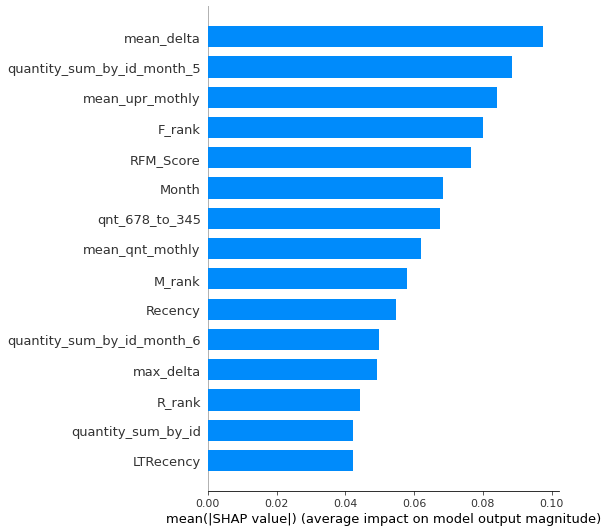

In [24]:
import shap
sv = cat.get_feature_importance(train_pool, reference_data=test_pool, type="ShapValues")[:, :-1]
shap.summary_plot(sv, xtrain, plot_type="bar", max_display=15)

In [33]:
imp2 = pd.DataFrame(index=X.columns)
cv = KFold(n_splits=5, shuffle=True, random_state=13)
cat_features=[col for col in X.columns if X[col].dtype == "object"]

for cnt, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    xtrain, xtest = X.iloc[train_idx, :], X.iloc[test_idx, :]
    ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]
    train_pool = Pool(xtrain, ytrain, cat_features=cat_features)
    test_pool = Pool(xtest, ytest, cat_features=cat_features)
    
    cat = CatBoostClassifier(depth=3, iterations=100, silent=True).fit(train_pool, eval_set=test_pool, early_stopping_rounds=30)
    sv = cat.get_feature_importance(train_pool, reference_data=test_pool, type="ShapValues")[:, :-1]
    ser = pd.Series(data=np.abs(sv).mean(axis=0), index=xtrain.columns, name=f"imp_{cnt}")
    
    imp2 = pd.merge(imp2, ser, left_index=True, right_index=True)
    
imp2["mean_imp"] = imp2.mean(axis=1)
imp2 = imp2.sort_values("mean_imp", ascending=False)
imp2.head(15)

,imp_0,imp_1,imp_2,imp_3,imp_4,mean_imp
LTRecency,0.042148,0.112898,0.126514,0.243409,0.169024,0.138799
mean_upr_mothly,0.084007,0.084279,0.190744,0.083763,0.168189,0.122196
R_rank,0.044287,0.067311,0.131894,0.067650,0.066513,0.075531
quantity_sum_by_id_month_5,0.088512,0.106523,0.047910,0.056379,0.067375,0.073340
quantity_sum_by_id,0.042158,0.039338,0.044562,0.152935,0.058200,0.067439
frequency,0.031882,0.102634,0.083810,0.083738,0.025979,0.065608
mean_delta,0.097428,0.035296,0.065503,0.081718,0.044107,0.064810
max_delta,0.049351,0.109953,0.094735,0.031828,0.035656,0.064305
mean_qnt_mothly,0.061976,0.129458,0.027619,0.040149,0.051701,0.062181
quantity_count_by_id,0.037058,0.039265,0.066203,0.091784,0.043590,0.055580


In [34]:
depth_range = np.arange(1, 6)
imp3 = pd.DataFrame(index=X.columns)

for depth in depth_range:
    model = CatBoostClassifier(depth=depth, iterations=100, silent=True).fit(x_train, y_train, cat_features=cat_features, early_stopping_rounds=30)
    ser = pd.Series(data=model.feature_importances_, index=model.feature_names_, name=f"imp_{depth}")
    
    imp3 = pd.merge(imp3, ser, left_index=True, right_index=True)
    
imp3["mean_imp"] = imp3.mean(axis=1)
imp3.sort_values("mean_imp", ascending=False, inplace=True)

imp3  # the earlier the feature involved in node splits the more important it is

,imp_1,imp_2,imp_3,imp_4,imp_5,mean_imp
mean_upr_mothly,22.234219,10.586651,8.034634,5.550414,3.377519,9.956687
LTRecency,11.116001,3.003755,4.825716,4.678704,2.418979,5.208631
min_delta,10.033940,6.981815,1.437377,2.576061,2.284058,4.662650
revenue_sum_by_id_month_5,3.174231,3.771286,6.552625,3.781684,4.247047,4.305375
quantity_sum_by_id_month_5,3.754721,6.461445,1.607787,5.989522,1.790513,3.920798
mean_qnt_mothly,10.254850,0.451192,2.434278,2.111890,2.804028,3.611247
unitprice_mean_by_id,1.294945,2.420828,2.430448,3.831321,4.474563,2.890421
rev_678_to_345,0.526214,2.991312,5.365735,2.192145,3.252146,2.865510
Recency,6.533432,1.047715,2.924153,1.347066,1.500166,2.670507
Month,0.851933,2.799075,1.789341,4.438275,3.231767,2.622078


In [36]:
model = CatBoostClassifier(depth=3, iterations=100, silent=True, allow_writing_files=True).fit(x_train, y_train, cat_features=cat_features, early_stopping_rounds=30)

In [51]:
fi = model.get_feature_importance(Pool(x_test, label=y_test, cat_features=cat_features), type="Interaction")

In [55]:
fi_new = []
for k,item in enumerate(fi):  
    first = x_test.dtypes.index[fi[k][0]]
    second = x_test.dtypes.index[fi[k][1]]
    if first != second:
        fi_new.append([first, second, fi[k][2]])

In [62]:
imp4 = pd.DataFrame(data=fi_new, columns=["feature1", "feature2", "strength"]).sort_values("strength", ascending=False)
imp4 = imp4.head(10)
imp4

,feature1,feature2,strength
0,DayWeek,quantity_sum_by_id_month_3,1.850525
1,quantity_sum_by_id_month_5,revenue_sum_by_id_month_6,1.486135
2,max_delta,revenue_sum_by_id_month_5,1.383136
3,unitprice_min_by_id,max_delta,1.351181
4,quantity_sum_by_id_month_4,quantity_sum_by_id_month_5,1.349676
5,revenue_sum_by_id_month_4,quantity_sum_by_id_month_8,1.347736
6,Revenue,stdv_upr_mothly,1.320723
7,StockCode2,quantity_min_by_id,1.261721
8,revenue_sum_by_id_month_2,revenue_sum_by_id_month_7,1.205033
9,unitprice_max_by_id,revenue_sum_by_id_month_7,1.202745


In [60]:
intersections = list(set(imp1["mean_imp"].head(20).index) | set(imp2["mean_imp"].head(20).index) | set(imp3["mean_imp"].head(20).index))
intersections

['DayWeek',
 'RFM_Score',
 'F_rank',
 'max_delta',
 'mean_qnt_mothly',
 'revenue_sum_by_id_month_4',
 'mean_upr_mothly',
 'revenue_sum_by_id_month_6',
 'frequency',
 'unitprice_mean_by_id',
 'Recency',
 'M_rank',
 'LTRecency',
 'revenue_sum_by_id_month_7',
 'R_rank',
 'Month',
 'qnt_678_to_345',
 'mean_delta',
 'quantity_sum_by_id',
 'quantity_sum_by_id_month_5',
 'rev_678_to_345',
 'quantity_count_by_id',
 'revenue_sum_by_id_month_5',
 'unitprice_min_by_id',
 'min_delta']

In [67]:
imp4_set = set(imp4.loc[(imp4["feature1"].isin(intersections) | imp4["feature2"].isin(intersections)), ["feature1", "feature2"]].values.flatten())
intersections = list(set(intersections) | set(imp4_set))
intersections

['DayWeek',
 'RFM_Score',
 'F_rank',
 'max_delta',
 'mean_qnt_mothly',
 'quantity_sum_by_id_month_4',
 'revenue_sum_by_id_month_4',
 'mean_upr_mothly',
 'revenue_sum_by_id_month_6',
 'frequency',
 'unitprice_mean_by_id',
 'Recency',
 'M_rank',
 'LTRecency',
 'revenue_sum_by_id_month_7',
 'R_rank',
 'Month',
 'revenue_sum_by_id_month_2',
 'qnt_678_to_345',
 'mean_delta',
 'quantity_sum_by_id',
 'unitprice_max_by_id',
 'quantity_sum_by_id_month_5',
 'quantity_sum_by_id_month_8',
 'quantity_sum_by_id_month_3',
 'rev_678_to_345',
 'quantity_count_by_id',
 'revenue_sum_by_id_month_5',
 'unitprice_min_by_id',
 'min_delta']

In [9]:
y.value_counts(normalize=True)

0    0.564255
1    0.435745
Name: target, dtype: float64

In [10]:
cb_params = {
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",
            "score_function": "Cosine",
            "depth": 3,
            "iterations": 1000,
            "learning_rate": 0.1,
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "task_type": "CPU",
            "use_best_model": True, 
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            "auto_class_weights": None,
            "bagging_temperature": 1,
            "max_bin": 16,  # tune
            "l2_leaf_reg": 69,
            "subsample": 0.8,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.6,
            # "max_ctr_complexity": 4,
            # "random_strength": 0.8,
}

categorical = [col for col in users.columns if users[col].dtype == "object" and col != "Text"]
textual = ["Text",]
# cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv = KFold(n_splits=6, shuffle=True, random_state=42)

_, _, _ = catboost_cross_validation(X, y, 
                                    params=cb_params, 
                                    rounds=50, 
                                    cv=cv, 
                                    calculate_ci=True, 
                                    categorical=categorical,
                                    textual=textual,
                                    preprocess=None,
                                    seed=42)

Fri Feb 10 22:17:25 2023, Cross-Validation, 3027 rows, 50 cols
Estimating best number of trees.
Evaluating cross validation with 36 trees.
Fold 1, Train score = 0.74921, Valid score = 0.76623
Fold 2, Train score = 0.76728, Valid score = 0.71369
Fold 3, Train score = 0.76141, Valid score = 0.73651
Fold 4, Train score = 0.75472, Valid score = 0.77199
Fold 5, Train score = 0.75983, Valid score = 0.74510
Fold 6, Train score = 0.75464, Valid score = 0.74979
Train score by each fold: [0.74921, 0.76728, 0.76141, 0.75472, 0.75983, 0.75464]
Valid score by each fold: [0.76623, 0.71369, 0.73651, 0.77199, 0.7451, 0.74979]
Train mean score by each fold:0.75785 +/- 0.00578
Valid mean score by each fold:0.74722 +/- 0.01926
**************************************************
OOF-score roc_auc_score: 0.74356
Expected metric value lies between: 0.72563 and 0.76105 with confidence of 95.0%


In [24]:
for fold, (train_idx, valid_idx) in enumerate(KFold(n_splits=6, shuffle=True, random_state=42).split(X, y)):
    if fold == 3:
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

In [14]:
scores, deltas = calculate_permutation_importance(CatBoostClassifier(**cb_params).fit(X.loc[train_idx], 
                                                                                      y[train_idx],
                                                                                      eval_set=[(X.loc[valid_idx], y[valid_idx]),],
                                                                                      cat_features=categorical, 
                                                                                      text_features=textual),
                                                 roc_auc_score,
                                                 X.loc[valid_idx],
                                                 y[valid_idx],
                                                 maximize=True,
                                                 probas=True
                                                 )

100%|██████████| 50/50 [00:02<00:00, 24.10it/s]


In [25]:
deltas[:20]  # with use_best_model=True

Month                         0.005560
max_delta                     0.001392
LTRecency                     0.001384
qnt_678_to_345                0.001368
mean_upr_mothly               0.001183
Recency                       0.001143
quantity_sum_by_id_month_5    0.000990
revenue_sum_by_id_month_7     0.000797
quantity_sum_by_id_month_1    0.000644
unitprice_mean_by_id          0.000378
RFM_Score                     0.000233
revenue_sum_by_id_month_5     0.000121
revenue_sum_by_id_month_2     0.000097
revenue_sum_by_id_month_8     0.000056
quantity_count_by_id          0.000040
quantity_min_by_id            0.000016
rev_678_to_345                0.000000
R_rank                        0.000000
quantity_sum_by_id_month_8    0.000000
revenue_sum_by_id_month_4     0.000000
dtype: float64

In [16]:
deltas = deltas[deltas>0].index.tolist()

In [32]:
#  with use_best_model=True, which mean that we fit our model using valid dataset also, as we are training until metrics obtained from it stops improving

deltas = ["Month", "max_delta", "LTRecency", "qnt_678_to_345", "mean_upr_mothly", "Recency", "quantity_sum_by_id_month_5", "revenue_sum_by_id_month_7",  
          "quantity_sum_by_id_month_1", "unitprice_mean_by_id", "RFM_Score", "revenue_sum_by_id_month_5", "revenue_sum_by_id_month_2", "revenue_sum_by_id_month_8",  
          "quantity_count_by_id", "quantity_min_by_id" ]

In [21]:
# Boruta
cb_params.update({"use_best_model": False, "iterations": 60})
classifier = CatBoostClassifier(**cb_params)
selector = BorutaShap(model=classifier, importance_measure='shap', classification=True)

selector.fit(X, y, n_trials=30, sample=False, normalize=True, verbose=True)

Warning there are missing values in your data !


  0%|          | 0/30 [00:00<?, ?it/s]

10 attributes confirmed important: ['Recency', 'mean_delta', 'quantity_count_by_id', 'mean_upr_mothly', 'quantity_sum_by_id_month_5', 'mean_qnt_mothly', 'LTRecency', 'quantity_sum_by_id', 'RFM_Score', 'frequency']
28 attributes confirmed unimportant: ['stdv_qnt_mothly', 'conseq', 'quantity_sum_by_id_month_12', 'Text', 'revenue_sum_by_id_month_4', 'max_delta', 'StockCode1', 'rev_678_to_345', 'revenue_sum_by_id_month_1', 'unitprice_min_by_id', 'quantity_sum_by_id_month_3', 'Month', 'unitprice_max_by_id', 'quantity_min_by_id', 'stdv_upr_mothly', 'revenue_sum_by_id_month_12', 'quantity_sum_by_id_month_2', 'quantity_sum_by_id_month_8', 'revenue_sum_by_id_month_8', 'Revenue', 'quantity_max_by_id', 'quantity_sum_by_id_month_4', 'return_cnt', 'DayWeek', 'revenue_sum_by_id_month_6', 'quantity_sum_by_id_month_1', 'quantity_sum_by_id_month_7', 'revenue_sum_by_id_month_2']
12 tentative attributes remains: ['revenue_sum_by_id_month_3', 'M_rank', 'min_delta', 'F_rank', 'unitprice_mean_by_id', 'qnt_6

In [10]:
boruta = ['Recency', 'mean_delta', 'quantity_count_by_id', 'mean_upr_mothly', 'quantity_sum_by_id_month_5', 'mean_qnt_mothly', 'LTRecency', 'quantity_sum_by_id', 'RFM_Score', 'frequency',
          'revenue_sum_by_id_month_3', 'M_rank', 'min_delta', 'F_rank', 'unitprice_mean_by_id', 'qnt_678_to_345', 'revenue_sum_by_id_month_5', 'R_rank', 
          'quantity_sum_by_id_month_6', 'unitprice_sum_by_id', 'revenue_sum_by_id_month_7', 'StockCode2']

In [38]:
cb_params = {
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",
            "score_function": "Cosine",
            "depth": 3,
            "iterations": 1000,
            "learning_rate": 0.01,
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "task_type": "CPU",
            "use_best_model": True,
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            #"auto_class_weights": None,
            #"bagging_temperature": 0,
            "max_bin": 16,  # tune
            "l2_leaf_reg": 100,
            "subsample": 1,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.9,
            # "max_ctr_complexity": 4,
            "random_strength": 7,
}

categorical = [col for col in deltas if users[col].dtype == "object" and col != "Text"]

# cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv = KFold(n_splits=6, shuffle=True, random_state=42)

_, _, _ = catboost_cross_validation(X[deltas], y, 
                                    params=cb_params, 
                                    rounds=50, 
                                    cv=cv, 
                                    score_fn=accuracy_score,  # fine balance
                                    calculate_ci=True, 
                                    categorical=categorical,
                                    textual=None,
                                    preprocess=None,
                                    best_iter="median",
                                    seed=42)

Fri Feb 10 21:08:10 2023, Cross-Validation, 3027 rows, 16 cols
Estimating best number of trees.
Evaluating cross validation with 64 trees.
Fold 1, Train score = 0.68517, Valid score = 0.71683
Fold 2, Train score = 0.69033, Valid score = 0.63762
Fold 3, Train score = 0.68239, Valid score = 0.66931
Fold 4, Train score = 0.68292, Valid score = 0.71230
Fold 5, Train score = 0.69441, Valid score = 0.68056
Fold 6, Train score = 0.69005, Valid score = 0.69444
Train score by each fold: [0.68517, 0.69033, 0.68239, 0.68292, 0.69441, 0.69005]
Valid score by each fold: [0.71683, 0.63762, 0.66931, 0.7123, 0.68056, 0.69444]
Train mean score by each fold:0.68754 +/- 0.00437
Valid mean score by each fold:0.68518 +/- 0.02695
**************************************************
OOF-score accuracy_score: 0.68517
Expected metric value lies between: 0.66829 and 0.70003 with confidence of 95.0%


In [39]:
cb_params = {
            "grow_policy": "Lossguide",
            "boosting_type": "Plain",
            "score_function": "L2",
            "depth": 6,
            "iterations": 1000,
            "learning_rate": 0.01,
            "loss_function": "Logloss",
            "eval_metric": "F1",
            "task_type": "CPU",
            "use_best_model": True,
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            #"auto_class_weights": None,
            #"bagging_temperature": 0,
            "max_bin": 16,  # tune
            "l2_leaf_reg": 100,
            "subsample": 1,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.9,
            # "max_ctr_complexity": 4,
            "random_strength": 7,
            "max_leaves": 18,
            "min_data_in_leaf": 10,
}

categorical = [col for col in deltas if users[col].dtype == "object" and col != "Text"]

# cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv = KFold(n_splits=6, shuffle=True, random_state=42)

_, _, _ = catboost_cross_validation(X[deltas], y, 
                                    params=cb_params, 
                                    rounds=50, 
                                    cv=cv, 
                                    score_fn=accuracy_score,  # fine balance
                                    calculate_ci=True, 
                                    categorical=categorical,
                                    textual=None,
                                    preprocess=None,
                                    best_iter="mean",
                                    seed=42)

Fri Feb 10 21:08:14 2023, Cross-Validation, 3027 rows, 16 cols
Estimating best number of trees.
Evaluating cross validation with 43 trees.
Fold 1, Train score = 0.68715, Valid score = 0.69901
Fold 2, Train score = 0.69627, Valid score = 0.65347
Fold 3, Train score = 0.68319, Valid score = 0.67327
Fold 4, Train score = 0.68371, Valid score = 0.71429
Fold 5, Train score = 0.69243, Valid score = 0.70040
Fold 6, Train score = 0.69283, Valid score = 0.67857
Train score by each fold: [0.68715, 0.69627, 0.68319, 0.68371, 0.69243, 0.69283]
Valid score by each fold: [0.69901, 0.65347, 0.67327, 0.71429, 0.7004, 0.67857]
Train mean score by each fold:0.68926 +/- 0.00490
Valid mean score by each fold:0.68650 +/- 0.02021
**************************************************
OOF-score accuracy_score: 0.68649
Expected metric value lies between: 0.67096 and 0.70368 with confidence of 95.0%


In [40]:
cb_params = {
            "grow_policy": "Depthwise",
            "boosting_type": "Plain",
            "score_function": "Cosine",
            "depth": 6,
            "iterations": 1000,
            "learning_rate": 0.1,
            "loss_function": "Logloss",
            "eval_metric": "F1",
            "task_type": "CPU",
            "use_best_model": True,
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            "auto_class_weights": None,
            "bagging_temperature": 10,
            "max_bin": 16,  # tune
            "l2_leaf_reg": 100,
            "subsample": 1,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.8,
            # "max_ctr_complexity": 4,
            "random_strength": 7,
            "min_data_in_leaf": 10,
}

categorical = [col for col in deltas if users[col].dtype == "object" and col != "Text"]

# cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

_, _, _ = catboost_cross_validation(X[deltas], y, 
                                    params=cb_params, 
                                    rounds=50, 
                                    cv=cv, 
                                    score_fn=accuracy_score,  # fine balance
                                    calculate_ci=True, 
                                    categorical=categorical,
                                    textual=None,
                                    preprocess=None,
                                    best_iter="mean",
                                    seed=42)

Fri Feb 10 21:08:18 2023, Cross-Validation, 3027 rows, 16 cols
Estimating best number of trees.
Evaluating cross validation with 49 trees.
Fold 1, Train score = 0.68172, Valid score = 0.69637
Fold 2, Train score = 0.69016, Valid score = 0.68647
Fold 3, Train score = 0.67474, Valid score = 0.66007
Fold 4, Train score = 0.68906, Valid score = 0.68977
Fold 5, Train score = 0.69420, Valid score = 0.69967
Fold 6, Train score = 0.69273, Valid score = 0.70957
Fold 7, Train score = 0.68906, Valid score = 0.70957
Fold 8, Train score = 0.68661, Valid score = 0.70861
Fold 9, Train score = 0.69248, Valid score = 0.66887
Fold 10, Train score = 0.68881, Valid score = 0.71854
Train score by each fold: [0.68172, 0.69016, 0.67474, 0.68906, 0.6942, 0.69273, 0.68906, 0.68661, 0.69248, 0.68881]
Valid score by each fold: [0.69637, 0.68647, 0.66007, 0.68977, 0.69967, 0.70957, 0.70957, 0.70861, 0.66887, 0.71854]
Train mean score by each fold:0.68796 +/- 0.00553
Valid mean score by each fold:0.69475 +/- 0.017

In [27]:
%%time
cb_params = {
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",
            "score_function": "Cosine",
            "depth": 3,
            "iterations": 1000,
            "learning_rate": 0.01,
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "task_type": "CPU",
            "use_best_model": True,
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            #"auto_class_weights": None,
            #"bagging_temperature": 0,
            "max_bin": 20,  # tune
            "l2_leaf_reg": 100,
            "subsample": 1,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.9,
            # "max_ctr_complexity": 4,
            "random_strength": 7,
}

categorical = [col for col in boruta if users[col].dtype == "object" and col != "Text"]

# cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv = KFold(n_splits=6, shuffle=True, random_state=42)

_, _, _ = catboost_cross_validation(X[boruta], y, 
                                    params=cb_params, 
                                    rounds=50, 
                                    cv=cv, 
                                    score_fn=accuracy_score,  # fine balance
                                    calculate_ci=True, 
                                    categorical=categorical,
                                    textual=None,
                                    preprocess=None,
                                    best_iter="mean",
                                    seed=42)

Sun Feb 12 20:38:47 2023, Cross-Validation, 3027 rows, 22 cols
Estimating best number of trees.
Evaluating cross validation with 249 trees.
Fold 1, Train score = 0.68398, Valid score = 0.70099
Fold 2, Train score = 0.69944, Valid score = 0.65347
Fold 3, Train score = 0.68755, Valid score = 0.69505
Fold 4, Train score = 0.68847, Valid score = 0.71032
Fold 5, Train score = 0.69045, Valid score = 0.69246
Fold 6, Train score = 0.69203, Valid score = 0.68849
Train score by each fold: [0.68398, 0.69944, 0.68755, 0.68847, 0.69045, 0.69203]
Valid score by each fold: [0.70099, 0.65347, 0.69505, 0.71032, 0.69246, 0.68849]
Train mean score by each fold:0.69032 +/- 0.00479
Valid mean score by each fold:0.69013 +/- 0.01780
**************************************************
OOF-score accuracy_score: 0.69012
Expected metric value lies between: 0.67460 and 0.70665 with confidence of 95.0%
CPU times: user 45.3 s, sys: 5.35 s, total: 50.6 s
Wall time: 14.5 s


In [25]:
cb_params = {
            "grow_policy": "Lossguide",
            "boosting_type": "Plain",
            "score_function": "L2",
            "depth": 6,
            "iterations": 1000,
            "learning_rate": 0.01,
            "loss_function": "Logloss",
            "eval_metric": "F1",
            "task_type": "CPU",
            "use_best_model": True,
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            #"auto_class_weights": None,
            #"bagging_temperature": 0,
            "max_bin": 16,  # tune
            "l2_leaf_reg": 100,
            "subsample": 1,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.9,
            # "max_ctr_complexity": 4,
            "random_strength": 7,
            "max_leaves": 18,  # only for lossguide, as building considering one best leaf split
            "min_data_in_leaf": 10,
}

categorical = [col for col in boruta if users[col].dtype == "object" and col != "Text"]

# cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv = KFold(n_splits=6, shuffle=True, random_state=42)

_, _, _ = catboost_cross_validation(X[boruta], y, 
                                    params=cb_params, 
                                    rounds=50, 
                                    cv=cv, 
                                    score_fn=accuracy_score,  # fine balance
                                    calculate_ci=True, 
                                    categorical=categorical,
                                    textual=None,
                                    preprocess=None,
                                    best_iter="mean",
                                    seed=42)

Fri Feb 10 22:27:42 2023, Cross-Validation, 3027 rows, 22 cols
Estimating best number of trees.
Evaluating cross validation with 13 trees.
Fold 1, Train score = 0.68715, Valid score = 0.69505
Fold 2, Train score = 0.68517, Valid score = 0.65347
Fold 3, Train score = 0.68715, Valid score = 0.68911
Fold 4, Train score = 0.68728, Valid score = 0.71429
Fold 5, Train score = 0.69322, Valid score = 0.69444
Fold 6, Train score = 0.68966, Valid score = 0.69048
Train score by each fold: [0.68715, 0.68517, 0.68715, 0.68728, 0.69322, 0.68966]
Valid score by each fold: [0.69505, 0.65347, 0.68911, 0.71429, 0.69444, 0.69048]
Train mean score by each fold:0.68827 +/- 0.00257
Valid mean score by each fold:0.68947 +/- 0.01812
**************************************************
OOF-score accuracy_score: 0.68946
Expected metric value lies between: 0.67294 and 0.70599 with confidence of 95.0%


In [32]:
%%time
cb_params = {
            "grow_policy": "Depthwise",
            "boosting_type": "Plain",
            "score_function": "Cosine",
            "depth": 6,
            "iterations": 1000,
            "learning_rate": 0.1,
            "loss_function": "Logloss",
            "eval_metric": "F1",
            "task_type": "CPU",
            "use_best_model": True,
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            "auto_class_weights": None,
            "bagging_temperature": 10,
            "max_bin": 12,  # tune
            "l2_leaf_reg": 30,
            "subsample": 1,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.8,
            # "max_ctr_complexity": 4,
            "random_strength": 7,
            "min_data_in_leaf": 10,
}

categorical = [col for col in boruta if users[col].dtype == "object" and col != "Text"]

# cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

_, _, _ = catboost_cross_validation(X[boruta], y, 
                                    params=cb_params, 
                                    rounds=50, 
                                    cv=cv, 
                                    score_fn=accuracy_score,  # fine balance
                                    calculate_ci=True, 
                                    categorical=categorical,
                                    textual=None,
                                    preprocess=None,
                                    best_iter="mean",
                                    seed=42)

Sun Feb 12 20:40:31 2023, Cross-Validation, 3027 rows, 22 cols
Estimating best number of trees.
Evaluating cross validation with 37 trees.
Fold 1, Train score = 0.70668, Valid score = 0.70957
Fold 2, Train score = 0.69567, Valid score = 0.67987
Fold 3, Train score = 0.70999, Valid score = 0.67327
Fold 4, Train score = 0.70888, Valid score = 0.69307
Fold 5, Train score = 0.69860, Valid score = 0.69967
Fold 6, Train score = 0.68906, Valid score = 0.71287
Fold 7, Train score = 0.67217, Valid score = 0.69637
Fold 8, Train score = 0.69431, Valid score = 0.72185
Fold 9, Train score = 0.69872, Valid score = 0.66887
Fold 10, Train score = 0.69578, Valid score = 0.71854
Train score by each fold: [0.70668, 0.69567, 0.70999, 0.70888, 0.6986, 0.68906, 0.67217, 0.69431, 0.69872, 0.69578]
Valid score by each fold: [0.70957, 0.67987, 0.67327, 0.69307, 0.69967, 0.71287, 0.69637, 0.72185, 0.66887, 0.71854]
Train mean score by each fold:0.69699 +/- 0.01048
Valid mean score by each fold:0.69739 +/- 0.017

In [13]:
# as we have balanced classes here it is useless, but it is just an implementation
# https://github.com/rahowa/catboost_focal_loss/blob/master/catboost_focal_loss.py

class FocallossObjective:
    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma
    
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        exponents = []
        for index in range(len(approxes)):
            exponents.append(np.exp(approxes[index]))

        result = []
        for index in range(len(targets)):
            p = exponents[index] / (1 + exponents[index])

            if targets[index] > 0.0:
                der1 = -((1 - p)**(self.gamma - 1)) * (self.gamma * np.log(p) * p + p - 1) / p
                der2 = self.gamma * ((1 - p)**self.gamma) * ((self.gamma * p - 1) * np.log(p) + 2 * (p-1))
            else:
                der1 = (p**(self.gamma - 1)) * (self.gamma * np.log(1 - p) - p) / (1 - p)
                der2 = p**(self.gamma - 2) * ((p * (2 * self.gamma*(p - 1) - p)) / (p - 1)**2 + (self.gamma - 1) * self.gamma * np.log(1 - p))

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))

        return result

In [8]:
class VecFocallossObjective:
    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma
        
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        exponents = np.exp(approxes)
        p = exponents / (1 + exponents)
        
        ones_indices = targets > 0.0
        zeros_indices = np.logical_not(ones_indices)
        
        neg_probs, pos_probs = p[zeros_indices], p[ones_indices]
        
        der1 = np.zeros_like(p)
        der2 = np.zeros_like(p)

        der1[ones_indices] = -((1 - pos_probs)**(self.gamma - 1)) * (self.gamma * np.log(pos_probs) * pos_probs + pos_probs - 1) / pos_probs
        der2[ones_indices] = self.gamma * ((1 - pos_probs)**self.gamma) * ((self.gamma * pos_probs - 1) * np.log(pos_probs) + 2 * (pos_probs-1))

        der1[zeros_indices] = (neg_probs**(self.gamma - 1)) * (self.gamma * np.log(1 - neg_probs) - neg_probs) / (1 - neg_probs)
        der2[zeros_indices] = neg_probs**(self.gamma - 2) * ((neg_probs * (2 * self.gamma*(neg_probs - 1) - neg_probs)) / (neg_probs - 1)**2 + (self.gamma - 1) * self.gamma * np.log(1 - neg_probs))

        if weights is not None:
            der1 *= weights
            der2 *= weights

        result = list(zip(der1.tolist(), der2.tolist()))

        return result

**Grads and hesses are needed for score function and leaf value estimation via Taylor Series**

$leaf = - \frac{\Sigma_i{w_i * l_i^`}}{\Sigma_i{w_i * l_i^" + \lambda}}$

In [36]:
%%time
cb_params = {
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",
            "score_function": "Cosine",
            "depth": 3,
            "iterations": 1000,
            "learning_rate": 0.01,
            "loss_function": VecFocallossObjective(gamma=2, alpha=0.25),
            "eval_metric": "F1",
            "custom_metric": ["F1", "Accuracy"],
            "task_type": "CPU",
            "use_best_model": True,
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            #"auto_class_weights": None,
            #"bagging_temperature": 0,
            "max_bin": 20,  # tune
            "l2_leaf_reg": 100,
            "subsample": 1,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.9,
            # "max_ctr_complexity": 4,
            "random_strength": 7,
}

categorical = [col for col in boruta if users[col].dtype == "object" and col != "Text"]

cv = KFold(n_splits=6, shuffle=True, random_state=42)

_, _, _ = catboost_cross_validation(X[boruta], y, 
                                    params=cb_params, 
                                    rounds=50, 
                                    cv=cv, 
                                    score_fn=accuracy_score,  # fine balance
                                    calculate_ci=True, 
                                    categorical=categorical,
                                    textual=None,
                                    preprocess=None,
                                    best_iter="mean",
                                    is_raw=True,  # always true for custom loss
                                    seed=42)

Sun Feb 12 20:45:01 2023, Cross-Validation, 3027 rows, 22 cols
Estimating best number of trees.
Evaluating cross validation with 60 trees.
Fold 1, Train score = 0.65464, Valid score = 0.66337
Fold 2, Train score = 0.66495, Valid score = 0.61782
Fold 3, Train score = 0.66297, Valid score = 0.62970
Fold 4, Train score = 0.61752, Valid score = 0.67659
Fold 5, Train score = 0.62029, Valid score = 0.64286
Fold 6, Train score = 0.61950, Valid score = 0.62103
Train score by each fold: [0.65464, 0.66495, 0.66297, 0.61752, 0.62029, 0.6195]
Valid score by each fold: [0.66337, 0.61782, 0.6297, 0.67659, 0.64286, 0.62103]
Train mean score by each fold:0.63998 +/- 0.02113
Valid mean score by each fold:0.64189 +/- 0.02172
**************************************************
OOF-score accuracy_score: 0.64189
Expected metric value lies between: 0.62503 and 0.65874 with confidence of 95.0%
CPU times: user 18.3 s, sys: 3.58 s, total: 21.9 s
Wall time: 16.2 s


**Add features**

In [9]:
# additional features 

users_prev["Month"] = users_prev["Month"].astype(int)
users_prev.loc[users_prev["Month"] == 12, "Month"] = 0

# first order month
users_prev["FirstMonth"] = users_prev.groupby("CustomerID")["Month"].transform("min")

# sum of revenue in first, first three and all months
first_month = users_prev[users_prev["Month"] == users_prev["FirstMonth"]].groupby("CustomerID", as_index=False)["Revenue"].sum().rename(columns={"Revenue": "R1M"})
three_months = users_prev[users_prev["Month"] <= users_prev["FirstMonth"]+2].groupby("CustomerID", as_index=False)["Revenue"].sum().rename(columns={"Revenue": "R3M"})
all_months = users_prev.groupby("CustomerID", as_index=False)["Revenue"].sum().rename(columns={"Revenue": "RAM"})

# life time values 
ltv = pd.merge(three_months, first_month)
ltv = pd.merge(all_months, ltv)
ltv["LTV_3"] = ltv["R3M"] - ltv["R1M"]
ltv["LTV_tot"] = ltv["RAM"] - ltv["R1M"]
ltv = ltv.drop(["RAM", "R3M", "R1M"], axis=1)

# life time values categories
ltv["LTV3_cut"] = pd.qcut(ltv["LTV_3"], q=3, labels=False).astype("str")
ltv["LTVT_cut"] = pd.qcut(ltv["LTV_tot"], q=4, labels=False).astype("str")

# average of moving average
tmp = users_prev.sort_values(["CustomerID", "InvoiceDate"])[users_prev["Revenue"] > 0].groupby(["CustomerID"])["Revenue"].rolling(4).mean().fillna(0).reset_index()  # method="bfill"
tmp = tmp[["CustomerID", "Revenue"]].rename(columns={"Revenue": "MvAvg"}).groupby("CustomerID", as_index=False)["MvAvg"].mean()  # nans sum = 95

tmp = pd.merge(ltv, tmp, how="left")

In [10]:
# subs and divs of last - i month to first month

users = users.reset_index().merge(tmp).set_index("CustomerID")
users = users.rename(columns={'revenue_sum_by_id_month_12': 'revenue_sum_by_id_month_0', 'quantity_sum_by_id_month_12': 'quantity_sum_by_id_month_0'})

# subs and divisions last month with previous
month_max = users_prev.groupby("CustomerID")["Month"].transform("max")
month_min = users_prev.groupby("CustomerID")["Month"].transform("min")
users1 = users.reset_index()[["CustomerID"]].copy(deep=True)

for i in range(6):
    condition = month_min != month_max - i
    running_div = users_prev.loc[(users_prev["Month"] == month_max - i) & condition].groupby("CustomerID")["Revenue"].sum() / \
                            users_prev.loc[(users_prev["Month"] == month_min) & condition].groupby("CustomerID")["Revenue"].sum()
    running_sub = users_prev.loc[(users_prev["Month"] == month_max - i) & condition].groupby("CustomerID")["Revenue"].sum() - \
                            users_prev.loc[(users_prev["Month"] == month_min) & condition].groupby("CustomerID")["Revenue"].sum()
    running_div.name = f"Revenue_div_{i}"
    running_sub.name = f"Revenue_sub_{i}"
    users1 = users1.merge(running_div, how="outer", on="CustomerID")
    users1 = users1.merge(running_sub, how="outer", on="CustomerID")
    
users1.fillna(0, inplace=True)

users = users.merge(users1, on="CustomerID")

In [11]:
# trends: last month / mean of others
last_month = users_prev.loc[(users_prev["Month"] == month_max)].groupby("CustomerID")["Revenue"].mean()
last_month.name = "last"
prev_months = users_prev.loc[(users_prev["Month"] != month_max)].groupby(["CustomerID", "Month"], as_index=False)["Revenue"].mean().drop("Month", axis=1).groupby("CustomerID").mean()
prev_months = prev_months.rename(columns={"Revenue": "other"})

tmp = pd.merge(last_month, prev_months, how="outer", on="CustomerID").reset_index()

tmp["trend"] = tmp["last"] / tmp["other"]
tmp.fillna(0, inplace=True)
tmp.replace([np.inf, -np.inf], 0, inplace=True)
tmp = tmp[["CustomerID", "trend"]]
tmp.loc[tmp["trend"] < 0, "trend"] = -1

users = users.merge(tmp, on="CustomerID", how="left")

In [12]:
# ratios of revenue (ALT: users_prev.groupby(["CustomerID", "Month"])["Revenue"].sum().unstack() - monthly revenue -> ratios) 
for p in combinations(range(8, 0, -1), r=2):
    users[f"revenue_{p[0]}_{p[1]}_ratio"] = users[f"revenue_sum_by_id_month_{p[0]}"] / users[f"revenue_sum_by_id_month_{p[1]}"]
    
users.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

In [13]:
X, y = users.drop("target", axis=1), users["target"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [25]:
# boruta selection
cb_params = {
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",
            "score_function": "Cosine",
            "depth": 3,
            "iterations": 1000,
            "learning_rate": 0.1,
            "loss_function": "Logloss",
            "eval_metric": "F1",
            "task_type": "CPU",
            "use_best_model": True, 
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            "auto_class_weights": None,
            "bagging_temperature": 1,
            "max_bin": 16,
            "l2_leaf_reg": 69,
            "subsample": 0.8,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.6,
            "max_ctr_complexity": 4,
            "random_strength": 2,
            #"cat_features": [col for col in X.columns if users[col].dtype in ["object", "category"]],
            #"text_features": ["Text"]
}

cb_params.update({"use_best_model": False, "iterations": 100})
classifier = CatBoostClassifier(**cb_params)
selector = BorutaShap(model=classifier, importance_measure='shap', classification=True)

selector.fit(X, y, n_trials=30, sample=False, normalize=True, verbose=True)

  0%|          | 0/30 [00:00<?, ?it/s]

6 attributes confirmed important: ['quantity_count_by_id', 'LTRecency', 'LTV_tot', 'Month', 'unitprice_mean_by_id', 'LTVT_cut']
79 attributes confirmed unimportant: ['MvAvg', 'quantity_sum_by_id_month_4', 'revenue_sum_by_id_month_3', 'revenue_8_7_ratio', 'revenue_5_1_ratio', 'revenue_6_3_ratio', 'revenue_5_3_ratio', 'revenue_6_4_ratio', 'mean_delta', 'CustomerID', 'Revenue_sub_1', 'revenue_sum_by_id_month_4', 'revenue_8_5_ratio', 'revenue_8_3_ratio', 'quantity_sum_by_id_month_7', 'revenue_2_1_ratio', 'quantity_sum_by_id_month_1', 'frequency', 'revenue_6_5_ratio', 'Revenue_sub_3', 'revenue_3_1_ratio', 'revenue_8_1_ratio', 'revenue_5_2_ratio', 'revenue_7_5_ratio', 'revenue_7_2_ratio', 'Text', 'unitprice_sum_by_id', 'quantity_max_by_id', 'revenue_7_4_ratio', 'Revenue_div_1', 'Revenue_div_4', 'revenue_sum_by_id_month_6', 'unitprice_max_by_id', 'StockCode1', 'revenue_6_1_ratio', 'revenue_sum_by_id_month_5', 'revenue_8_4_ratio', 'quantity_sum_by_id_month_3', 'max_delta', 'quantity_sum_by_id_

In [14]:
boruta = ['quantity_count_by_id', 'LTRecency', 'LTV_tot', 'Month', 'unitprice_mean_by_id', 'LTVT_cut', 'min_delta', 'quantity_sum_by_id', 'RFM_Score', 
          'mean_qnt_mothly', 'F_rank', 'Revenue_div_2', 'R_rank', 'Recency', 'revenue_sum_by_id_month_7', 'rev_678_to_345', 'mean_upr_mothly', 'quantity_sum_by_id_month_5']

In [32]:
cb_params = {
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",
            "score_function": "Cosine",
            "depth": 3,
            "iterations": 1000,
            "learning_rate": 0.1,
            "loss_function": "Logloss",
            "eval_metric": "Accuracy",
            "task_type": "CPU",
            "use_best_model": True, 
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            "auto_class_weights": None,
            "bagging_temperature": 1,
            "max_bin": 16, 
            "l2_leaf_reg": 69,
            "subsample": 0.8,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.6,
            "max_ctr_complexity": 4,
            "random_strength": 2,
}

categorical = [col for col in X.columns if X[col].dtype == "object" and col != "Text"]
textual = ["Text",]

cv = KFold(n_splits=6, shuffle=True, random_state=42)

_, _, _ = catboost_cross_validation(X, y, 
                                    params=cb_params, 
                                    rounds=50, 
                                    cv=cv, 
                                    score_fn=accuracy_score,  # fine balance
                                    calculate_ci=True, 
                                    categorical=categorical,
                                    textual=textual,
                                    preprocess=None,
                                    best_iter="mean",
                                    is_raw=True,  # always true for custom loss
                                    seed=42)

Sat Mar  4 18:43:22 2023, Cross-Validation, 3027 rows, 97 cols
Estimating best number of trees.
Evaluating cross validation with 15 trees.
Fold 1, Train score = 0.67803, Valid score = 0.71881
Fold 2, Train score = 0.69429, Valid score = 0.65941
Fold 3, Train score = 0.67209, Valid score = 0.69505
Fold 4, Train score = 0.68133, Valid score = 0.71032
Fold 5, Train score = 0.68609, Valid score = 0.69643
Fold 6, Train score = 0.68094, Valid score = 0.68651
Train score by each fold: [0.67803, 0.69429, 0.67209, 0.68133, 0.68609, 0.68094]
Valid score by each fold: [0.71881, 0.65941, 0.69505, 0.71032, 0.69643, 0.68651]
Train mean score by each fold:0.68213 +/- 0.00687
Valid mean score by each fold:0.69442 +/- 0.01889
**************************************************
OOF-score accuracy_score: 0.69442
Expected metric value lies between: 0.67822 and 0.70962 with confidence of 95.0%


In [15]:
%%time
# model with boruta

cb_params = {
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",
            "score_function": "Cosine",
            "depth": 8,
            "iterations": 1000,
            "learning_rate": 0.01,
            "loss_function": "Logloss",
            "eval_metric": "F1",
            "task_type": "CPU",
            "use_best_model": True,
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            "auto_class_weights": None,
            # "bagging_temperature": 10,
            "max_bin": 16,
            "l2_leaf_reg": 30,
            "subsample": 1,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.7,
            "max_ctr_complexity": 2,
            "random_strength": 10,
            # "min_data_in_leaf": 10,
}

categorical = [col for col in boruta if users[col].dtype == "object" and col != "Text"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)

_, oof_preds, _ = catboost_cross_validation(X[boruta], y, 
                                            params=cb_params, 
                                            rounds=100, 
                                            cv=cv, 
                                            score_fn=accuracy_score,  # fine balance
                                            calculate_ci=True, 
                                            categorical=categorical,
                                            textual=None,
                                            preprocess=None,
                                            best_iter="mean",
                                            seed=42)

Sat Mar 18 22:15:15 2023, Cross-Validation, 3027 rows, 18 cols
Estimating best number of trees.
Evaluating cross validation with 23 trees.
Fold 1, Train score = 0.68943, Valid score = 0.71617
Fold 2, Train score = 0.69420, Valid score = 0.67987
Fold 3, Train score = 0.69714, Valid score = 0.67327
Fold 4, Train score = 0.69310, Valid score = 0.69307
Fold 5, Train score = 0.69090, Valid score = 0.71287
Fold 6, Train score = 0.69273, Valid score = 0.71287
Fold 7, Train score = 0.68833, Valid score = 0.70627
Fold 8, Train score = 0.68954, Valid score = 0.73179
Fold 9, Train score = 0.69394, Valid score = 0.66887
Fold 10, Train score = 0.68917, Valid score = 0.71192
Train score by each fold: [0.68943, 0.6942, 0.69714, 0.6931, 0.6909, 0.69273, 0.68833, 0.68954, 0.69394, 0.68917]
Valid score by each fold: [0.71617, 0.67987, 0.67327, 0.69307, 0.71287, 0.71287, 0.70627, 0.73179, 0.66887, 0.71192]
Train mean score by each fold:0.69185 +/- 0.00268
Valid mean score by each fold:0.70070 +/- 0.01979

In [32]:
%%time

# model with boruta and custom function
cb_params = {
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",
            "score_function": "Cosine",
            "depth": 4,
            "iterations": 1000,
            "learning_rate": 0.01,
            "loss_function": VecFocallossObjective(gamma=2, alpha=0.25),
            "eval_metric": "F1",
            "custom_metric": ["F1", "Accuracy"],
            "task_type": "CPU",
            "use_best_model": True,
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            "auto_class_weights": None,
            #"bagging_temperature": 0,
            "max_bin": 20,  # tune
            "l2_leaf_reg": 100,
            "subsample": 1,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 1,
            "max_ctr_complexity": 2,
            "random_strength": 7,
}

categorical = [col for col in boruta if users[col].dtype == "object" and col != "Text"]

cv = KFold(n_splits=6, shuffle=True, random_state=42)

_, _, _ = catboost_cross_validation(X[boruta], y, 
                                             params=cb_params, 
                                             rounds=50, 
                                             cv=cv, 
                                             score_fn=accuracy_score,  # fine balance
                                             calculate_ci=True, 
                                             categorical=categorical,
                                             textual=None,
                                             preprocess=None,
                                             best_iter="mean",
                                             is_raw=True,  # always true for custom loss
                                             seed=42)

Fri Mar 10 19:08:41 2023, Cross-Validation, 3027 rows, 18 cols
Estimating best number of trees.
Evaluating cross validation with 5 trees.
Fold 1, Train score = 0.65504, Valid score = 0.65743
Fold 2, Train score = 0.65464, Valid score = 0.62376
Fold 3, Train score = 0.65741, Valid score = 0.61584
Fold 4, Train score = 0.66825, Valid score = 0.68651
Fold 5, Train score = 0.66786, Valid score = 0.66270
Fold 6, Train score = 0.65161, Valid score = 0.65873
Train score by each fold: [0.65504, 0.65464, 0.65741, 0.66825, 0.66786, 0.65161]
Valid score by each fold: [0.65743, 0.62376, 0.61584, 0.68651, 0.6627, 0.65873]
Train mean score by each fold:0.65914 +/- 0.00653
Valid mean score by each fold:0.65083 +/- 0.02407
**************************************************
OOF-score accuracy_score: 0.65081
Expected metric value lies between: 0.63198 and 0.66832 with confidence of 95.0%
CPU times: user 8.22 s, sys: 1.47 s, total: 9.7 s
Wall time: 6.68 s


In [16]:
%%time
cb_params = {
            "grow_policy": "Depthwise",
            "boosting_type": "Plain",
            "score_function": "Cosine",
            "depth": 6,
            "iterations": 1000,
            "learning_rate": 0.01,
            "loss_function": "Logloss",
            "eval_metric": "F1",
            "task_type": "CPU",
            "use_best_model": True,
            "thread_count": -1,
            "silent": True,
            "random_seed": 42,
            "allow_writing_files": False,
            "auto_class_weights": None,
            "bagging_temperature": 10,
            "max_bin": 16, 
            "l2_leaf_reg": 30,
            # "subsample": 1,
            "bootstrap_type": "Bayesian",
            "colsample_bylevel": 0.8,
            # "max_ctr_complexity": 4,
            "random_strength": 7,
            "min_data_in_leaf": 8,
}

categorical = [col for col in boruta if users[col].dtype == "object" and col != "Text"]

# cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

_, oof_predsd, _ = catboost_cross_validation(X[boruta], y, 
                                             params=cb_params, 
                                             rounds=100, 
                                             cv=cv, 
                                             score_fn=accuracy_score,  # fine balance
                                             calculate_ci=True, 
                                             categorical=categorical,
                                             textual=None,
                                             preprocess=None,
                                             best_iter="mean",
                                             seed=42)

Sat Mar 18 22:15:28 2023, Cross-Validation, 3027 rows, 18 cols
Estimating best number of trees.
Evaluating cross validation with 39 trees.
Fold 1, Train score = 0.69347, Valid score = 0.70297
Fold 2, Train score = 0.68833, Valid score = 0.68977
Fold 3, Train score = 0.69824, Valid score = 0.66997
Fold 4, Train score = 0.69824, Valid score = 0.67987
Fold 5, Train score = 0.69567, Valid score = 0.68647
Fold 6, Train score = 0.69053, Valid score = 0.72937
Fold 7, Train score = 0.69126, Valid score = 0.70627
Fold 8, Train score = 0.69028, Valid score = 0.73510
Fold 9, Train score = 0.69688, Valid score = 0.66887
Fold 10, Train score = 0.69982, Valid score = 0.72185
Train score by each fold: [0.69347, 0.68833, 0.69824, 0.69824, 0.69567, 0.69053, 0.69126, 0.69028, 0.69688, 0.69982]
Valid score by each fold: [0.70297, 0.68977, 0.66997, 0.67987, 0.68647, 0.72937, 0.70627, 0.7351, 0.66887, 0.72185]
Train mean score by each fold:0.69427 +/- 0.00382
Valid mean score by each fold:0.69905 +/- 0.022

In [17]:
# CI intersection

scores_sym = create_bootstrap_metrics(y, oof_preds, metric=accuracy_score, n_samlpes=3000)
scores_dep = create_bootstrap_metrics(y, oof_predsd, metric=accuracy_score, n_samlpes=3000)

In [19]:
from statsmodels.stats.proportion import proportions_ztest

proportions_ztest(count=[sum(oof_preds), sum(oof_predsd)], nobs=[len(oof_preds), len(oof_predsd)])

(2.7508499250380787, 0.005944086829575476)

In [23]:
from scipy.stats import ttest_ind, ttest_rel
# 341 or more measurements/surveys are needed to have a confidence level of 95% that the real value is within ±5% of the measured/surveyed value.
np.random.seed(42)

ttest_ind(np.random.choice(scores_sym, size=341), np.random.choice(scores_dep, size=341), equal_var=False)

Ttest_indResult(statistic=2.653832109637592, pvalue=0.008144580194365612)

In [24]:
np.mean(scores_sym), np.mean(scores_dep)

(0.7004525933267262, 0.6991047241493228)

In [25]:
from statsmodels.stats.weightstats import zconfint

zconfint(scores_sym), zconfint(scores_dep)  # in practice for small datasets the CI often have intersection.
# with confidence of 95% we may conclude that the true value of metric lies in given intervals

((0.6999378658045845, 0.7009673208488678),
 (0.6986069656235346, 0.6996024826751109))

In [38]:
ttest_rel(np.random.choice(scores_sym, size=589), np.random.choice(scores_dep, size=589))  # bonferoni

Ttest_relResult(statistic=4.58287212359076, pvalue=5.604218376581401e-06)

In [29]:
def compare_models(oof_preds: list, 
                   y_true: np.ndarray, 
                   metric: callable,
                   n_train: int, 
                   n_test: int, 
                   model_names = None,
                   sample: int = 0,
                   conf_level: float = 0.95,
                   rope_interval: list = [-0.01, 0.01],
                   n_samples: int = 3000) -> pd.DataFrame:
    
    from scipy.stats import t, ttest_rel
    from itertools import combinations
    from math import factorial
    
    if model_names is None:
        model_names = [f"model_{i+1}" for i in range(len(oof_preds))]
        
    n_comparisons = (factorial(len(oof_preds)) / (factorial(2) * factorial(len(oof_preds) - 2)))
    scores = [np.array(create_bootstrap_metrics(y_true, oof_pred, metric, n_samples)) for oof_pred in oof_preds]
    if sample != 0:
        scores = [np.random.choice(score, size=sample) for score in scores]
        
    df = scores[0].shape[0] - 1
    
    def corrected_std(differences, n_train, n_test):
        kr = len(differences)
        corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
        corrected_std = np.sqrt(corrected_var)
        return corrected_std
    
    def compute_corrected_ttest(differences, df, n_train, n_test):
        mean = np.mean(differences)
        std = corrected_std(differences, n_train, n_test)
        t_stat = mean / std
        p_val = t.sf(np.abs(t_stat), df)
        return t_stat, p_val
    
    pairwise_ttest, pairwise_bayesian, t_rel = [], [], []
    
    for model_i, model_k in combinations(range(len(scores)), r=2):
        model_i_scores = scores[model_i]
        model_k_scores = scores[model_k]
        
        differences = model_i_scores - model_k_scores
        t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
        p_val *= n_comparisons  # bonferroni correction
        p_val = 1 if p_val > 1 else p_val
        
        pairwise_ttest.append([model_names[model_i], model_names[model_k], t_stat, p_val])
        
        t_post = t(df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test))
        model_i_prob = t_post.cdf(rope_interval[0])  # probability of model 1 worse than 2
        model_k_prob = 1 - t_post.cdf(rope_interval[1])  # probability of model 2 worse than 1
        
        rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])  # probability of model 1 is equal 2
        
        cred_interval = list(t_post.interval(conf_level))  # true difference lies inside interval
        pairwise_bayesian.append([model_i_prob, model_k_prob, rope_prob, cred_interval[0], cred_interval[1]])
        
        if sample == 0:
            tres = ttest_rel(model_i_scores, model_k_scores)
        else:
            tres = ttest_rel(np.random.choice(model_i_scores, size=sample), np.random.choice(model_k_scores, size=sample))
        statistic, p_val = tres[0], tres[1]
        # ci = tres.confidence_interval(confidence_level=0.95)
        
        t_rel.append([statistic, p_val])
            
    result = pd.DataFrame(data=np.hstack([pairwise_ttest, pairwise_bayesian, t_rel]), index=[f"compare_{i+1}" for i in range(int(n_comparisons))],
                                         columns=["model_1", "model_2", "t_stat", "corr_p_val", "1_worse_2", 
                                                  "2_worse_1", "2_equal_1", "ci_lower", "ci_upper", "rel_stat", "non_corr_p_val"])
    result.iloc[:, 2:] = result.iloc[:, 2:].astype("float").apply(lambda x: np.round(x, 4))
    
    return result

In [36]:
compare_models([oof_preds, oof_predsd], y, accuracy_score, len(X), len(oof_preds), sample=589)

,model_1,model_2,t_stat,corr_p_val,1_worse_2,2_worse_1,2_equal_1,ci_lower,ci_upper,rel_stat,non_corr_p_val
compare_1,model_1,model_2,0.1137,0.4548,0.1706,0.2343,0.595,-0.0221,0.0248,2.0212,0.0437
